# 필요 라이브러리 import

In [1]:
import pandas as pd                                          #데이터 분석 라이브러리
from sklearn.decomposition import PCA                        #주성분 분석 라이브러리
import numpy as np                                           # 계산 라이브러리
from sklearn.preprocessing import MinMaxScaler, StandardScaler    # scale 라이브러리

from sklearn.model_selection import train_test_split         # 데이터 분할 라이브러리
from sklearn.model_selection import cross_validate           # Kfold 라이브러리
from sklearn.model_selection import cross_val_score          # Kfold 라이브러리
from sklearn.model_selection import StratifiedKFold          # Kfold 라이브러리


from sklearn.neighbors import KNeighborsClassifier           # KNN 라이브러리
from sklearn.svm import SVC                                  # SVM Classifier 라이브러리
from sklearn.tree import DecisionTreeClassifier              # 결정나무분류 라이브러리
from sklearn.linear_model import LogisticRegression          # 로지스틱 회귀 라이브러리
from sklearn.ensemble import RandomForestClassifier          # 랜덤 포레스트 라이브러리
from bayes_opt import BayesianOptimization                   # 베이시안 라이브러리   


from sklearn.metrics import make_scorer                      # 평가용 라이브러리
from sklearn.metrics import f1_score                         # f1  라이브러리
from sklearn.metrics import accuracy_score                   # accuracy 라이브러리 



import matplotlib.pyplot as plt                              # 그래프 라이브러리
from sklearn.ensemble import VotingClassifier                # 보팅 앙상블 라이브러리
import seaborn as sns                                        # boxplot 을 위한 라이브러리
import joblib

# data 불러오기

In [2]:
File = pd.read_csv("../../Data/final_data/training/geo_data/geo_training_seq_data.csv") # 데이터 불러오기

In [5]:
Floodfile = File.drop(['Unnamed: 0','FLOOD'], axis = 1)  # 필요 독립변수
Floodclass = File['FLOOD']                                            # 종속 변수 

In [6]:
Floodfile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796 entries, 0 to 795
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PUMP_RATIO                 796 non-null    float64
 1   Hourly_Rainfall_Weight     796 non-null    float64
 2   Impervious_Surface_Weight  796 non-null    float64
 3   SLOPE_AVG_Weight           796 non-null    float64
 4   HIGH_Weight                796 non-null    float64
 5   F_WEIGHT                   796 non-null    float64
dtypes: float64(6)
memory usage: 37.4 KB


# minmaxscaler
## data scale 과정

In [7]:
scaler = MinMaxScaler()
scaler.fit(Floodfile)
Floodfile = scaler.transform(Floodfile)  # data sclae 과정 -> minmaxscaler 를 통해 0~1의 값으로 변환

# PCA

In [8]:
pca = PCA(n_components=4)  # 주성분 분석 후 -> 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(Floodfile)  
Floodfile = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2','principal component3', 'principal component4'])
# pca를 통해 나온 4가지 주성분을 독립변수로 사용하도록 데이터 변형

In [9]:
Floodfile

,principal component1,principal component2,principal component3,principal component4
0,0.063927,-0.681744,0.053284,0.082002
1,0.058611,-0.630972,0.127358,-0.069406
2,0.056012,-0.606144,0.163581,-0.143445
3,0.039158,-0.683262,0.053191,0.266411
4,0.034175,-0.635663,0.122636,0.124467
...,...,...,...,...
791,0.025624,0.696675,0.074157,-0.569671
792,-0.171061,0.993761,0.527883,-0.238038
793,-0.036974,0.794668,0.228558,-0.458647
794,-0.170018,0.992751,0.527118,-0.238898


# data split
## 8 : 2 으로 training 과 test 구분

In [10]:
x_train, x_test, y_train, y_test = train_test_split(Floodfile, Floodclass , test_size=0.2, random_state=400)

# BayesianOptimization

In [11]:
skfolds=StratifiedKFold(n_splits=5, random_state=400 ,shuffle = True)

# 베이지안최적화과정에서 Kfold 를 사용하기위해 설정

## KNN

In [12]:
KNN_search_point = {'k': (3,20), 'leaf': (1,30)}  # 각 옵션들의 범위를 정해줌

gp_params = {"alpha":1e-10}
scores_all = []
k_all = []
leaf_all=[]

def KNN_opt(k,leaf):
    cvscores = []
    
    for train_index, val_index in skfolds.split(x_train, y_train):

        x_skftrain, x_val = x_train.values[train_index], x_train.values[val_index]
        Y_skftrain, Y_val = np.array(y_train)[train_index],np.array(y_train)[val_index]
        # train 데이터를 5fold 를 사용해 검증하며 옵션 최적값 탐색을 위해 데이터 분할
        
        KNNmodel = KNeighborsClassifier(n_neighbors = int(k),weights = 'distance', leaf_size= leaf ) 
        # KNN 모델에 사용되는 옵션들의 최적값 탐색  
        
        KNNmodel2 = KNNmodel.fit(x_skftrain,Y_skftrain)        # 모델학습
        y_pred = KNNmodel2.predict(x_val)                      # 예측

        report = f1_score(Y_val, y_pred, average='weighted')  # F1
        cvscores.append(report)                               # 결과들을 리스트로 저장
    
    
    scores_all.append(np.mean(cvscores))
    k_all.append(int(k))
    
    return np.mean(cvscores)

result = BayesianOptimization(KNN_opt, KNN_search_point,    random_state=10,    verbose=2) 
result.maximize(acq='ucb',n_iter=15, kappa=2.576, init_points=1 , **gp_params)
# 타겟과 범위를 정해준뒤에 그 결과를 확인 n_iter를 통해 확인 횟수 조절가능

|   iter    |  target   |     k     |   leaf    |
-------------------------------------------------
|  1        |  0.787    |  16.11    |  1.602    |
|  2        |  0.792    |  11.49    |  15.67    |
|  3        |  0.7856   |  19.94    |  29.62    |
|  4        |  0.7766   |  3.05     |  29.51    |
|  5        |  0.7847   |  9.691    |  11.73    |
|  6        |  0.7856   |  20.0     |  12.22    |
|  7        |  0.7888   |  12.34    |  29.92    |
|  8        |  0.7869   |  14.54    |  18.79    |
|  9        |  0.7856   |  19.96    |  1.171    |
|  10       |  0.7767   |  3.185    |  1.288    |
|  11       |  0.7766   |  3.025    |  19.96    |
|  12       |  0.7793   |  8.799    |  23.06    |
|  13       |  0.7855   |  15.56    |  11.01    |
|  14       |  0.781    |  10.0     |  1.065    |
|  15       |  0.7793   |  8.896    |  16.62    |
|  16       |  0.7856   |  19.99    |  22.34    |


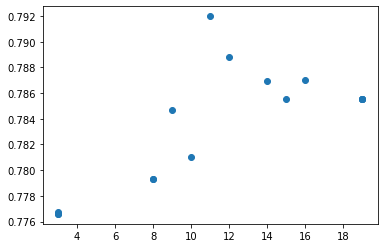

In [13]:
plt.scatter(k_all, scores_all)

## SVM

In [14]:
# KNN 과 동일 옵션만 바뀐 상태로 범위를 지정해주고 최적값을 탐색
SVM_search_point = {'k': (1,30), 'gamma': (0.001,20)}

gp_params = {"alpha":1e-10}
scores_all = []
k_all = []
gamma_all = []

def SVM_opt(k,gamma):
    cvscores = []
    
    for train_index, val_index in skfolds.split(x_train, y_train):
        
        x_skftrain, x_val = x_train.values[train_index],x_train.values[val_index]
        Y_skftrain, Y_val = np.array(y_train)[train_index],np.array(y_train)[val_index]

        SVMmodel = SVC( C= 10 , kernel='rbf' , probability = True ) # SVM  
        
        SVMmodel2 = SVMmodel.fit(x_skftrain,Y_skftrain)      # 모델학습
        y_pred = SVMmodel2.predict(x_val)                    # 예측

        report = f1_score(Y_val, y_pred, average='weighted') # F1
        cvscores.append(report)
    
    scores_all.append(np.mean(cvscores))
    k_all.append(int(k))
    return np.mean(cvscores)

result = BayesianOptimization(SVM_opt, SVM_search_point, random_state=10, verbose=2) 
result.maximize(acq='ucb',n_iter=20, kappa=2.576, init_points=1 , **gp_params)

|   iter    |  target   |   gamma   |     k     |
-------------------------------------------------
|  1        |  0.7543   |  15.43    |  1.602    |
|  2        |  0.7543   |  9.991    |  15.67    |
|  3        |  0.7543   |  19.99    |  28.33    |
|  4        |  0.7543   |  11.74    |  1.589    |
|  5        |  0.7543   |  5.961    |  23.67    |
|  6        |  0.7543   |  19.88    |  24.52    |
|  7        |  0.7543   |  8.438    |  16.68    |
|  8        |  0.7543   |  7.618    |  16.74    |
|  9        |  0.7543   |  19.39    |  1.478    |
|  10       |  0.7543   |  8.601    |  13.42    |
|  11       |  0.7543   |  18.86    |  15.88    |
|  12       |  0.7543   |  8.405    |  25.53    |
|  13       |  0.7543   |  17.16    |  24.23    |
|  14       |  0.7543   |  11.14    |  12.68    |
|  15       |  0.7543   |  19.99    |  6.617    |
|  16       |  0.7543   |  16.12    |  22.13    |
|  17       |  0.7543   |  13.08    |  16.15    |
|  18       |  0.7543   |  10.77    |  18.62    |


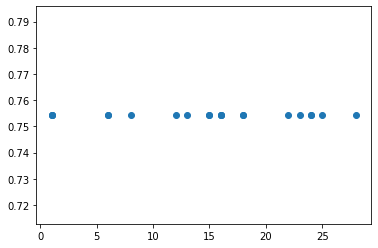

In [15]:
plt.scatter(k_all, scores_all)

## Decision Tree

In [16]:
DT_search_point = { 'k': (1,30), 'leaf' : ( 2, 30), 'split': (2,30) }

gp_params = {"alpha":1e-10}
scores_all = []
k_all = []
leaf_all = []
split_all = []

def DT_opt(k,leaf,split):
    cvscores = []
    
    for train_index, val_index in skfolds.split(x_train, y_train):
        x_skftrain, x_val = x_train.values[train_index],x_train.values[val_index]
        Y_skftrain, Y_val = np.array(y_train)[train_index],np.array(y_train)[val_index]

        DTmodel = DecisionTreeClassifier(criterion='gini',
                                         max_depth=int(k), 
                                         min_samples_leaf= int(leaf),
                                         min_samples_split= int(split)) #DT  
        
        
        DTmodel2 = DTmodel.fit(x_skftrain,Y_skftrain)      # 모델학습
        y_pred = DTmodel2.predict(x_val)                    # 예측

        report = f1_score(Y_val, y_pred, average='weighted') # F1
        cvscores.append(report)
    
    scores_all.append(np.mean(cvscores))
    k_all.append(int(k))
    leaf_all.append(int(leaf))
    split_all.append(split)

    
    return np.mean(cvscores)

result = BayesianOptimization(DT_opt, DT_search_point, random_state=10, verbose=2) 
result.maximize(acq='ucb',n_iter=15, kappa=2.576, init_points=1 , **gp_params)

|   iter    |  target   |     k     |   leaf    |   split   |
-------------------------------------------------------------
|  1        |  0.7602   |  23.37    |  2.581    |  19.74    |
|  2        |  0.7217   |  26.25    |  23.01    |  19.33    |
|  3        |  0.7213   |  1.0      |  2.0      |  2.0      |
|  4        |  0.7213   |  1.0      |  2.0      |  30.0     |
|  5        |  0.765    |  29.62    |  2.082    |  30.0     |
|  6        |  0.7712   |  29.69    |  2.631    |  3.316    |
|  7        |  0.7635   |  29.3     |  2.185    |  7.692    |
|  8        |  0.7768   |  26.16    |  2.399    |  4.576    |
|  9        |  0.7469   |  4.83     |  29.29    |  2.527    |
|  10       |  0.754    |  3.447    |  28.4     |  29.89    |
|  11       |  0.7431   |  17.14    |  12.54    |  2.017    |
|  12       |  0.7112   |  28.91    |  29.77    |  2.124    |
|  13       |  0.7098   |  28.94    |  29.74    |  29.95    |
|  14       |  0.7759   |  21.68    |  2.045    |  2.19     |
|  15   

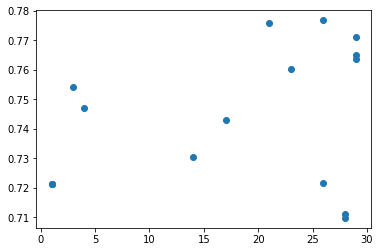

In [17]:
plt.scatter(k_all, scores_all)

## Logistic Regression

In [18]:
LR_search_point = { 'k': (1,50)}

gp_params = {"alpha":1e-10}
scores_all = []
k_all = []

def LR_opt(k):
    cvscores = []
    
    for train_index, val_index in skfolds.split(x_train, y_train):
        x_skftrain, x_val = x_train.values[train_index],x_train.values[val_index]
        Y_skftrain, Y_val = np.array(y_train)[train_index],np.array(y_train)[val_index]

        LRmodel = LogisticRegression(C= int(k) , multi_class= 'auto') #LR  
        
        
        LRmodel2 = LRmodel.fit(x_skftrain,Y_skftrain)      # 모델학습
        y_pred = LRmodel2.predict(x_val)                    # 예측

        report = f1_score(Y_val, y_pred, average='weighted') # F1
        cvscores.append(report)
    
    scores_all.append(np.mean(cvscores))
    k_all.append(int(k))
    
    return np.mean(cvscores)

result = BayesianOptimization(LR_opt, LR_search_point, random_state=10, verbose=2) 
result.maximize(acq='ucb',n_iter=20, kappa=2.576, init_points=1 , **gp_params)

|   iter    |  target   |     k     |
-------------------------------------
|  1        |  0.7262   |  38.79    |
|  2        |  0.7207   |  18.73    |
|  3        |  0.7262   |  50.0     |
|  4        |  0.7207   |  30.04    |
|  5        |  0.7038   |  1.0      |
|  6        |  0.7262   |  45.0     |
|  7        |  0.7262   |  41.56    |
|  8        |  0.7207   |  11.1     |
|  9        |  0.7262   |  48.05    |
|  10       |  0.7262   |  40.02    |
|  11       |  0.7262   |  39.05    |
|  12       |  0.7262   |  45.21    |
|  13       |  0.7262   |  46.73    |
|  14       |  0.7262   |  48.92    |
|  15       |  0.7262   |  39.98    |
|  16       |  0.7262   |  49.56    |
|  17       |  0.7262   |  42.46    |
|  18       |  0.7262   |  47.32    |
|  19       |  0.7262   |  47.94    |
|  20       |  0.7262   |  45.55    |
|  21       |  0.7262   |  48.61    |


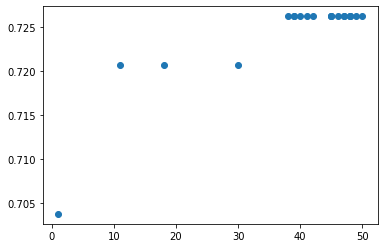

In [20]:
plt.scatter(k_all, scores_all)

# Voting ensemble
## 사용 된 모델 : KNN, SVM, Decision Tree, Logistic Regression

In [21]:
KNN_model = KNeighborsClassifier(n_neighbors = 11, weights = 'distance')

SVM_model = SVC( C= 10 , kernel='rbf' , probability = True , gamma = 20 )

DT_model = DecisionTreeClassifier(criterion='gini', max_depth=29, min_samples_leaf= 2, min_samples_split= 3)

RF_model = RandomForestClassifier( n_estimators= 20,min_samples_split = 2, min_samples_leaf= 6, max_depth=15)

In [22]:
ensemble=VotingClassifier(
        estimators=[('KNN',KNN_model),
                   ('SVM',SVM_model),
                   ('DT',DT_model),
                   ('RF',RF_model)]
        ,voting='soft')

# Voting 모델 안에 각 모델들을 묶어주기

In [23]:
KNN_model.fit(x_train,y_train)
SVM_model.fit(x_train,y_train)
DT_model.fit(x_train,y_train)
RF_model.fit(x_train,y_train)
ensemble.fit(x_train,y_train)

# 각 모델에  train 데이터 학습시키고
# 모델들이 묶어진 voting 앙상블에도 train 데이터를 학습

VotingClassifier(estimators=[('KNN',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=11,
                                                   p=2, weights='distance')),
                             ('SVM',
                              SVC(C=10, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma=20, kernel='rbf', max_iter=-1,
                                  probability=True, random_...
                                                     criterion='gini',
                                                     max_depth=15,
       

# 교차검증 적용

In [24]:
SKF = StratifiedKFold( n_splits = 5,  shuffle = True, random_state = 16)

In [25]:
KNN_scores=cross_validate(KNN_model, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
SVM_scores=cross_validate(SVM_model, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
DT_scores=cross_validate(DT_model, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
RF_scores=cross_validate(RF_model, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
ensemble_scores=cross_validate(ensemble, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))

# 각 모델들의 성능 평가를 위해 교차검증 실시  확인할 score는 f1 임

In [26]:
print(KNN_scores)
print(SVM_scores)
print(DT_scores)
print(RF_scores)
print(ensemble_scores)

# validate 를 통해 모델 학습시간, 모델 가동시간, f1_score 를 확인 가능

{'fit_time': array([0.00194597, 0.00195909, 0.00185347, 0.00097275, 0.0009737 ]), 'score_time': array([0.00291705, 0.00194716, 0.00247431, 0.00291157, 0.00292301]), 'test_score': array([0.7032967 , 0.7       , 0.79545455, 0.60674157, 0.75294118])}
{'fit_time': array([0.02305818, 0.03155875, 0.02042103, 0.02141213, 0.02141285]), 'score_time': array([0.00189447, 0.00097871, 0.00194693, 0.00194716, 0.00208759]), 'test_score': array([0.65263158, 0.64583333, 0.77083333, 0.64444444, 0.62650602])}
{'fit_time': array([0.00194693, 0.00194621, 0.00194669, 0.00097322, 0.00194645]), 'score_time': array([0.00097299, 0.0009737 , 0.00097322, 0.00194669, 0.00097322]), 'test_score': array([0.73563218, 0.66666667, 0.66666667, 0.53012048, 0.66666667])}
{'fit_time': array([0.02433324, 0.02628088, 0.024333  , 0.02743578, 0.02627969]), 'score_time': array([0.00292015, 0.00291991, 0.00291753, 0.00292015, 0.00292015]), 'test_score': array([0.71910112, 0.71910112, 0.73170732, 0.66666667, 0.68292683])}
{'fit_ti

In [27]:
KNN_f1_score = KNN_scores["test_score"].mean()
SVN_f1_score = SVM_scores["test_score"].mean()
DT_f1_score = DT_scores["test_score"].mean()
RF_f1_score = RF_scores["test_score"].mean()
ensemble_f1_score = ensemble_scores["test_score"].mean()


print("f1_score: {0: .4f}".format(KNN_f1_score))
print("f1_score: {0: .4f}".format(SVN_f1_score))
print("f1_score: {0: .4f}".format(DT_f1_score))
print("f1_score: {0: .4f}".format(RF_f1_score))
print("f1_score: {0: .4f}".format(ensemble_f1_score))

# 나온 값들의 평균을 확인을 위해 mean 값을 print로 표시

f1_score:  0.7117
f1_score:  0.6680
f1_score:  0.6532
f1_score:  0.7039
f1_score:  0.6969


# test 데이터 예측 정확도

In [28]:
pred_KNN = KNN_model.predict(x_test)
pred_SVM = SVM_model.predict(x_test)
pred_DT = DT_model.predict(x_test)
pred_RF = RF_model.predict(x_test)

# 각 모델들의 test 데이터에 대한 예측 결과를 알기 위해 각각 예측실행

In [29]:
y_predict= ensemble.predict(x_test)

# 적용 모델인 Voting ensemble 예측

In [30]:
print('KNN',f1_score(y_test,pred_KNN))
print('SVM',f1_score(y_test,pred_SVM))
print('DT',f1_score(y_test,pred_DT))
print('RF',f1_score(y_test,pred_RF))
print('Voting',f1_score(y_test,y_predict))          # 각 모델들의 f1_Score 확인

KNN 0.7068965517241379
SVM 0.689655172413793
DT 0.6608695652173914
RF 0.7787610619469026
Voting 0.6902654867256638


# 2020 년 사고사례 데이터

In [35]:
accident = pd.read_excel("초량동 지형 강우량.xlsx")   # 초량지하차도 지형정보 와 당일 시간당 강우량 데이터

In [36]:
Busanaccident = accident.drop(['SLOPE_L','SLOPE_H','FLOOD','MANHOLES_RATIO'], axis = 1)  # 불필요 컬럼제거
Busanaccidentclass = accident['FLOOD']                                                   # 종속 변수 

In [37]:
Busanaccident.rename(columns={'R_W_SUM':'Hourly_Rainfall_Weight','HOUR_RAINFALL':'Hourly_Rainfall','IMP_SUR_RATIO':'Impervious_Surface',
                              'IMP_W_SUM':'Impervious_Surface_Weight'},inplace=True)  
#가중치 적용을 위해 컬럼명 수정하여 사용

In [38]:
accident = pd.read_excel("./초량동 지형 강우량.xlsx")   # 초량지하차도 지형정보 와 당일 시간당 강우량 데이터
accident

Busanaccident = accident.drop(['SLOPE_L','SLOPE_H','FLOOD','MANHOLES_RATIO'], axis = 1)  # 불필요 컬럼제거
Busanaccidentclass = accident['FLOOD']                                                   # 종속 변수 

Busanaccident.rename(columns={'R_W_SUM':'Hourly_Rainfall_Weight','HOUR_RAINFALL':'Hourly_Rainfall','IMP_SUR_RATIO':'Impervious_Surface',
                              'IMP_W_SUM':'Impervious_Surface_Weight'},inplace=True)  
#가중치 적용을 위해 컬럼명 수정하여 사용

Busanaccident['SLOPE_AVG'] = Busanaccident['SLOPE_AVG'].astype(float)
Busanaccident['HIGH'] = Busanaccident['HIGH'].astype(float)

rain_weight = Busanaccident['Hourly_Rainfall'].copy()
imp_weight = Busanaccident['Impervious_Surface'].copy()
slope_weight = Busanaccident['SLOPE_AVG'].copy()
high_weight = Busanaccident['HIGH'].copy()




## 강우량 가중치

for idx,col in enumerate(Busanaccident['Hourly_Rainfall']):
    if col <= 15:
        rain_weight[idx] = col / (46)
    elif col > 15 and col <= 35:
        rain_weight[idx] = col / (18 * 2**2)
    elif col > 35 and col <= 60:
        rain_weight[idx] = col / (17 * 3**2)
    elif col > 60 and col <= 80:
        rain_weight[idx] = col / (11 * 4**2)
    elif col > 80:
        rain_weight[idx] = col / (6.28 * 5**2)

## 불투수면 가중치

for idx,col in enumerate(Busanaccident['Impervious_Surface']):
    if col <= 15:
        imp_weight[idx] = col / 6.66
    elif col > 15 and col <= 25:
        imp_weight[idx] = col / (20 * 2)
    elif col > 25 and col <= 40:
        imp_weight[idx] = col / (13.33 * 3)
    elif col > 40 and col <= 55:
        imp_weight[idx] = col / (33.33 * 4)
    elif col > 55:
        imp_weight[idx] = col / (26.67 * 5)

## 경사도 가중치

#Busanaccident['SLOPE_AVG_Weight'] = Busanaccident['SLOPE_AVG']

for idx,col in enumerate(Busanaccident['SLOPE_AVG']):
    if col <= 10:
        slope_weight[idx] = col / (41.67 / 5**2 )
    elif col > 10 and col <= 15:
        slope_weight[idx] = col / (25 / 4**2)
    elif col > 15 and col <= 25:
        slope_weight[idx] = col / (16.67 / 3**2)
    elif col > 25 and col <= 50:
        slope_weight[idx] = col / (8.33 / 2**2)
    elif col > 50:
        slope_weight[idx] = col / (8.33 / 1**2)

## 고도 가중치

#Busanaccident['HIGH_Weight'] = Busanaccident['HIGH']

for idx,col in enumerate(Busanaccident['HIGH']):
    if col <= 20:
        high_weight[idx] = col / (79.62 / 1**2)
    elif col > 20 and col <= 40:
        high_weight[idx] = col / (10.18 / 2**2)
    elif col > 40 and col <= 60:
        high_weight[idx] = col / (4.63 / 3**2)
    elif col > 60 and col <= 80:
        high_weight[idx] = col / (2.78 / 4**2)
    elif col > 80:
        high_weight[idx] = col / (2.78 / 5**2)

slope_weight

Busanaccident['Hourly_Rainfall_Weight'] = rain_weight
Busanaccident['Impervious_Surface_Weight'] = imp_weight
Busanaccident['SLOPE_AVG_Weight'] = slope_weight
Busanaccident['HIGH_Weight'] = high_weight


## 가중치 값을 구한뒤 불필요한 변수 다시 제거

Busanaccident = Busanaccident.drop(['SLOPE_AVG','Impervious_Surface','Hourly_Rainfall','HIGH'], axis = 1)

Busanaccident

Busanaccident = Busanaccident[['Hourly_Rainfall_Weight','Impervious_Surface_Weight','SLOPE_AVG_Weight','HIGH_Weight','F_WEIGHT','PUMP_RATIO']]

In [39]:
Busanaccident

,Hourly_Rainfall_Weight,Impervious_Surface_Weight,SLOPE_AVG_Weight,HIGH_Weight,F_WEIGHT,PUMP_RATIO
0,0.000000,0.434346,0.599952,0.050239,0.017,1.982160e-07
1,0.000000,0.434346,0.599952,0.050239,0.017,1.982160e-07
2,0.000000,0.434346,0.599952,0.050239,0.017,1.982160e-07
3,0.000000,0.434346,0.599952,0.050239,0.017,1.982160e-07
4,0.010870,0.434346,0.599952,0.050239,0.017,1.982160e-07
5,0.000000,0.434346,0.599952,0.050239,0.017,1.982160e-07
6,0.000000,0.434346,0.599952,0.050239,0.017,1.982160e-07
7,0.021739,0.434346,0.599952,0.050239,0.017,1.982160e-07
8,0.076087,0.434346,0.599952,0.050239,0.017,1.982160e-07
9,0.000000,0.434346,0.599952,0.050239,0.017,1.982160e-07


## 정리된 데이터에 scale 적용

In [40]:
scaler = MinMaxScaler()
scaler.fit(Busanaccident)
Busanaccident = scaler.transform(Busanaccident)                         # sccler 적용

## 학습 데이터와 동일한 데이터 형태로 만들기위해 pca사용

In [41]:
pca = PCA(n_components=4)
printcipalComponents = pca.fit_transform(Busanaccident)
Busanaccident = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2','principal component3', 'principal component4'])

## 초량동에 대한 예측 실시


In [42]:
accident_predict= ensemble.predict(Busanaccident)                       # 학습된 모델을 활용해 사고사례 예측 실시

In [43]:
print(accident_predict)                                                 # 예측값 확인

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]


In [45]:
joblib.dump(ensemble, '../../Data/final_data/model/geo_model/ensemble.pkl')
joblib.dump(ensemble, '../../Web/ensemble.pkl')

['../../Web/ensemble.pkl']